In [66]:
import numpy as np
import pandas as pd
from aq_edge.datautils.air_quality_analysis import (setup_plotting, load_station_data, show_data_overview, calculate_station_statistics, plot_time_series, plot_distributions, analyze_correlations, analyze_missing_data, analyze_outliers, generate_pdf_report, generate_executive_summary_pdf)

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_dataframes(dataframes, names=None, output_file="plot.html",
                    static_figsize=(12, 4), interactive_width=1200,
                    interactive_height_per_df=400):
    """
    Plots a static preview in the console (Matplotlib) and
    saves an interactive Plotly figure as HTML (not shown in console).

    Parameters:
        dataframes (pd.DataFrame or list of pd.DataFrame): DataFrame(s) with DatetimeIndex
        names (list of str): Optional list of names for each DataFrame (used in subplot titles)
        output_file (str): Path to save the HTML file
        static_figsize (tuple): Size of Matplotlib figure (width, height per subplot)
        interactive_width (int): Width of Plotly figure
        interactive_height_per_df (int): Height per subplot in Plotly figure
    """

    # Ensure dataframes is a list
    if isinstance(dataframes, pd.DataFrame):
        dataframes = [dataframes]

    if not isinstance(dataframes, list) or not all(isinstance(df, pd.DataFrame) for df in dataframes):
        raise ValueError("dataframes must be a pandas DataFrame or a list of DataFrames")

    # Default names if not provided
    if names is None:
        names = [f"DataFrame {i+1}" for i in range(len(dataframes))]
    elif len(names) != len(dataframes):
        raise ValueError("Length of 'names' must match number of dataframes")

    # --- Static Preview (Matplotlib) ---
    fig_static, axes = plt.subplots(len(dataframes), 1,
                                    figsize=(static_figsize[0], static_figsize[1]*len(dataframes)),
                                    sharex=False)
    if len(dataframes) == 1:
        axes = [axes]

    for i, (df, ax) in enumerate(zip(dataframes, axes)):
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError(f"DataFrame {i+1} does not have a DatetimeIndex")
        df.select_dtypes(include="number").plot(ax=ax, title=names[i])
        ax.set_xlabel("Time")
        ax.set_ylabel("Values")

    plt.tight_layout()
    plt.show()

    # --- Interactive Plot (Plotly, saved to HTML) ---
    fig_interactive = make_subplots(
        rows=len(dataframes), cols=1, shared_xaxes=True,
        subplot_titles=names
    )

    for i, df in enumerate(dataframes, start=1):
        for col in df.select_dtypes(include="number").columns:
            fig_interactive.add_trace(
                go.Scatter(x=df.index, y=df[col], mode="lines", name=f"{names[i-1]}-{col}"),
                row=i, col=1
            )

    fig_interactive.update_layout(
        height=interactive_height_per_df*len(dataframes),
        width=interactive_width,
        title_text="Interactive Time Series Plots"
    )

    # Save only
    fig_interactive.write_html(output_file)
    print(f"Interactive plot saved to {output_file}")


In [68]:
def clip_outliers_mean_std(df, n_std=4):
    """
    Clips values above mean + n*std for all numeric columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        n_std (int or float): Number of standard deviations for threshold (default=3)

    Returns:
        pd.DataFrame: Copy of DataFrame with clipped values
    """
    df_clipped = df.copy()

    for col in df_clipped.select_dtypes(include="number"):
        mean = df_clipped[col].mean()
        std = df_clipped[col].std()
        upper = mean + n_std * std

        df_clipped[col] = df_clipped[col].clip(upper=upper)

    return df_clipped

In [69]:
def impute_dataframe(df, numeric_limit=2):
    """
    Performs imputation on a DataFrame:
      - Numeric columns: forward fill then backward fill with a limit
      - Categorical columns: fill with mode

    Parameters:
        df (pd.DataFrame): Input DataFrame
        numeric_limit (int): Maximum consecutive NaNs to fill for numeric columns

    Returns:
        pd.DataFrame: DataFrame with imputed values
    """
    df_imputed = df.copy()

    # Numeric columns
    for col in df_imputed.select_dtypes(include='number'):
        df_imputed[col] = df_imputed[col].fillna(method='ffill', limit=numeric_limit)
        df_imputed[col] = df_imputed[col].fillna(method='bfill', limit=numeric_limit)

    # Categorical / object columns
    for col in df_imputed.select_dtypes(include='object'):
        mode_val = df_imputed[col].mode()
        if not mode_val.empty:
            df_imputed[col] = df_imputed[col].fillna(mode_val[0])

    return df_imputed

In [39]:
import pandas as pd

def merge_timeseries(df_list, how='outer',
                     fill=False, limit=2,
                     csv_path="merged_timeseries.csv", parquet_path="merged_timeseries.parquet"):
    """
    Merges a list of time series DataFrames (with DatetimeIndex) and optionally fills missing values.

    Parameters:
        df_list (list): List of pandas DataFrames with DatetimeIndex
        how (str): How to merge: 'outer', 'inner', 'left', 'right' (default='outer')
        fill (bool): Whether to perform forward/backward fill on numeric columns (default=False)
        limit (int or None): Maximum consecutive NaNs to fill forward or backward (default=None)
        csv_path (str): Path to save CSV
        parquet_path (str): Path to save Parquet

    Returns:
        pd.DataFrame: Merged (and optionally filled) time series DataFrame
    """
    if not isinstance(df_list, list) or not all(isinstance(df, pd.DataFrame) for df in df_list):
        raise ValueError("df_list must be a list of pandas DataFrames")
    if not all(isinstance(df.index, pd.DatetimeIndex) for df in df_list):
        raise ValueError("All DataFrames must have a DatetimeIndex")

    # Merge iteratively on index
    merged_df = df_list[0].copy()
    for df in df_list[1:]:
        merged_df = merged_df.merge(df, left_index=True, right_index=True, how=how)

    # Optional filling
    if fill:
        for col in merged_df.select_dtypes(include='number'):
            merged_df[col] = merged_df[col].fillna(method='ffill', limit=limit)
        for col in merged_df.select_dtypes(include='number'):
            merged_df[col] = merged_df[col].fillna(method='bfill', limit=limit)

    # Save
    merged_df.to_csv(csv_path, index=True)
    merged_df.to_parquet(parquet_path, index=True)

    print(f"Merged time series saved as CSV: {csv_path}")
    print(f"Merged time series saved as Parquet: {parquet_path}")

    return merged_df


In [40]:
def remove_outliers(df, bounds=None, method='drop', verbose=True):
    """
    Domain-specific outlier removal for air quality data with customizable bounds and methods

    Parameters:
        df (pd.DataFrame): Input DataFrame
        bounds (dict): Dictionary with column names as keys and (lower, upper) tuples as values.
                      If None, uses default bounds for common air quality parameters.
        method (str): Method to handle outliers:
                     'clip' - Clip values to bounds
                     'drop' - Drop rows containing outliers
        verbose (bool): Print information about outliers found and removed

    Returns:
        pd.DataFrame: DataFrame with outliers handled according to method
    """
    df_result = df.copy()

    # Default bounds if not provided
    if bounds is None:
        bounds = {
            'Temp.': (-40, 85),
            'Hum.': (0, 100),
            'CO2': (400, 5000),
            'VOC': (0, 1000),
        }

    original_rows = len(df_result)
    outlier_info = {}

    if method == 'clip':
        for col, (lower, upper) in bounds.items():
            if col in df_result.columns:
                # Count outliers before clipping
                below_lower = (df_result[col] < lower).sum()
                above_upper = (df_result[col] > upper).sum()
                total_outliers = below_lower + above_upper

                if verbose and total_outliers > 0:
                    outlier_info[col] = {
                        'below_lower': below_lower,
                        'above_upper': above_upper,
                        'total': total_outliers
                    }

                # Clip values
                df_result[col] = df_result[col].clip(lower=lower, upper=upper)

    elif method == 'drop':
        # Create a mask for rows to keep (start with all True)
        keep_mask = pd.Series(True, index=df_result.index)

        for col, (lower, upper) in bounds.items():
            if col in df_result.columns:
                # Identify outliers in this column
                col_outliers = (df_result[col] < lower) | (df_result[col] > upper)

                if verbose and col_outliers.sum() > 0:
                    below_lower = (df_result[col] < lower).sum()
                    above_upper = (df_result[col] > upper).sum()
                    outlier_info[col] = {
                        'below_lower': below_lower,
                        'above_upper': above_upper,
                        'total': col_outliers.sum()
                    }

                # Update mask: keep only rows that don't have outliers in this column
                keep_mask = keep_mask & (~col_outliers)

        # Apply the mask to drop rows with outliers
        df_result = df_result.loc[keep_mask]

    else:
        raise ValueError("method must be either 'clip' or 'drop'")

    # Print summary if verbose
    if verbose:
        if method == 'clip' and outlier_info:
            print("Outliers clipped:")
            for col, info in outlier_info.items():
                print(f"  {col}: {info['total']} outliers ({info['below_lower']} below, {info['above_upper']} above)")
        elif method == 'drop':
            rows_removed = original_rows - len(df_result)
            if rows_removed > 0:
                print(f"Rows dropped: {rows_removed} ({rows_removed/original_rows*100:.1f}%)")
                if outlier_info:
                    print("Outliers by column:")
                    for col, info in outlier_info.items():
                        print(f"  {col}: {info['total']} outliers ({info['below_lower']} below, {info['above_upper']} above)")
            else:
                print("No outliers found - no rows dropped")

    return df_result

In [41]:
def analyze_nan_values(df, show_details=True):
    """
    Comprehensive NaN analysis for a DataFrame

    Parameters:
        df (pd.DataFrame): Input DataFrame
        show_details (bool): Whether to show detailed breakdown

    Returns:
        pd.DataFrame: Summary of NaN statistics
    """
    nan_summary = pd.DataFrame({
        'Column': df.columns,
        'NaN_Count': df.isnull().sum().values,
        'NaN_Percentage': (df.isnull().sum() / len(df) * 100).values,
        'Non_NaN_Count': df.notna().sum().values,
        'Total_Rows': len(df)
    })

    # Filter columns with NaN values
    columns_with_nan = nan_summary[nan_summary['NaN_Count'] > 0]

    if show_details:
        print(f"DataFrame shape: {df.shape}")
        print(f"Total NaN values: {df.isnull().sum().sum()}")
        print(f"Columns with NaN: {len(columns_with_nan)}/{len(df.columns)}")
        print("\nNaN Summary:")
        print(columns_with_nan.to_string(index=False))

    return nan_summary

In [42]:
def resample_dataframe(df, freq='15min', debug=False):
    """
    Best practice resampling with proper handling of different data types.

    Parameters:
        df (pd.DataFrame): Input DataFrame with DatetimeIndex
        freq (str): Resampling frequency (e.g., '15min', '1H', '5T')
        debug (bool): Whether to print debug information

    Returns:
        pd.DataFrame: Resampled DataFrame
    """
    if debug:
        print(f"Original shape: {df.shape}")
        print(f"Index type: {type(df.index)}")
        print(f"Index frequency: {df.index.freq}")

    # Validate datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")

    # Sort and remove duplicates
    df_clean = df.sort_index()
    df_clean = df_clean[~df_clean.index.duplicated(keep='first')]

    # Separate column types
    numeric_cols = df_clean.select_dtypes(include=['number']).columns
    categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
    boolean_cols = df_clean.select_dtypes(include=['bool']).columns

    # Build aggregation dictionary
    agg_dict = {}

    # Numeric: use mean (most common for sensor data)
    for col in numeric_cols:
        agg_dict[col] = 'mean'

    # Categorical: use mode with proper fallback
    for col in categorical_cols:
        agg_dict[col] = lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None

    # Boolean: use most frequent (mode)
    for col in boolean_cols:
        agg_dict[col] = lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None

    # Resample
    resampled = df_clean.resample(freq).agg(agg_dict)

    if debug:
        print(f"Resampled shape: {resampled.shape}")
        print(f"Missing values after resampling: {resampled.isnull().sum().sum()}")

    return resampled

In [43]:
def process_station_data(station_data, stations, timestamp_col='Timestamp',
                        custom_bounds=None, columns_drop=None, n_std=4,
                        outlier_method='drop', verbose=True):
    """
    Process multiple station DataFrames with datetime indexing and outlier removal.

    Parameters:
        station_data (dict): Dictionary containing station DataFrames
        stations (list): List of station names to process
        timestamp_col (str): Name of timestamp column to convert to datetime index
        custom_bounds (dict): Domain-specific bounds for outlier removal
        columns_drop (list): Columns to drop after processing
        n_std (int/float): Number of standard deviations for statistical outlier clipping
        outlier_method (str): Method for domain outlier removal ('drop' or 'clip')
        verbose (bool): Whether to print processing information and NaN analysis

    Returns:
        dict: Dictionary of processed DataFrames with station names as keys
    """
    if custom_bounds is None:
        custom_bounds = {
            'Temp.': (-40, 85),
            'Hum.': (0, 100),
            'CO2': (400, 5000),
            'VOC': (0, 1000),
        }

    if columns_drop is None:
        columns_drop = ['Station']

    processed_stations = {}
    nan_analyses = {}

    if verbose:
        print(f"Processing {len(stations)} stations: {stations}")
        print("-" * 50)

    for station in stations:
        if station not in station_data:
            print(f"Warning: Station {station} not found in station_data")
            continue

        if verbose:
            print(f"Processing {station}...")

        # Get station dataframe
        df = station_data[station].copy()

        # Convert timestamp to datetime and set as index
        if timestamp_col in df.columns:
            df[timestamp_col] = pd.to_datetime(df[timestamp_col])
            df = df.set_index(timestamp_col, drop=True)

        # Remove statistical outliers (mean + n*std)
        # df = clip_outliers_mean_std(df, n_std=n_std)

        # Remove domain-specific outliers
        df = remove_outliers(df, bounds=custom_bounds, method=outlier_method, verbose=False)

        # Drop specified columns
        columns_to_drop = [col for col in columns_drop if col in df.columns]
        if columns_to_drop:
            df = df.drop(columns=columns_to_drop)

        # Store processed dataframe
        processed_stations[station] = df

        # Analyze NaN values
        nan_analysis = analyze_nan_values(df, show_details=verbose)
        nan_analyses[station] = nan_analysis

        if verbose:
            print(f"  Shape after processing: {df.shape}")
            print()

    if verbose:
        print("Processing complete!")
        print(f"Processed stations: {list(processed_stations.keys())}")

    return processed_stations

In [44]:
def process_stations_complete(processed_stations, stations, freq='10min', numeric_limit=4, verbose=True):
    """
    Complete processing pipeline: resample, impute, analyze, and dropna for multiple stations.

    Parameters:
        processed_stations (dict): Dictionary of processed DataFrames from process_station_data
        stations (list): List of station names to process (['PGB', 'USAM', 'UTEC'])
        freq (str): Resampling frequency (e.g., '10min', '15min', '1H')
        numeric_limit (int): Maximum consecutive NaNs to fill for numeric columns
        verbose (bool): Whether to print processing information

    Returns:
        dict: Dictionary with processed DataFrames ready for analysis
    """
    final_stations = {}

    if verbose:
        print(f"Complete processing for {len(stations)} stations: {stations}")
        print(f"Frequency: {freq}, Numeric limit: {numeric_limit}")
        print("-" * 60)

    for station in stations:
        if station not in processed_stations:
            print(f"Warning: Station {station} not found in processed_stations")
            continue

        if verbose:
            print(f"Processing {station}...")

        # Get the processed dataframe
        df = processed_stations[station]

        # Resample
        df_resampled = resample_dataframe(df, freq=freq, debug=False)

        # Impute
        df_imputed = impute_dataframe(df_resampled, numeric_limit=numeric_limit)

        # Analyze NaN before dropna
        if verbose:
            print(f"  NaN analysis before dropna:")
            analyze_nan_values(df_imputed, show_details=False)

        # Drop remaining NaN values
        df_final = df_imputed.dropna()

        # Final NaN analysis
        if verbose:
            print(f"  Original shape: {df.shape}")
            print(f"  After resampling: {df_resampled.shape}")
            print(f"  After imputation: {df_imputed.shape}")
            print(f"  Final shape (after dropna): {df_final.shape}")

            final_analysis = analyze_nan_values(df_final, show_details=False)
            if final_analysis['NaN_Count'].sum() == 0:
                print("  ✓ No NaN values remaining")
            print()

        # Store final result
        final_stations[station] = df_final

    if verbose:
        print("Complete processing finished!")
        print(f"Final stations ready: {list(final_stations.keys())}")

    return final_stations

In [45]:
def save_station_data(stations_dict, stations, base_path="data/air/processed/",
                     save_csv=True, save_parquet=True, verbose=True):
    """
    Save station DataFrames to CSV and/or Parquet formats.

    Parameters:
        stations_dict (dict): Dictionary with station names as keys and DataFrames as values
        stations (list): List of station names to save (['PGB', 'USAM', 'UTEC'])
        base_path (str): Base directory path for saving files
        save_csv (bool): Whether to save CSV files
        save_parquet (bool): Whether to save Parquet files
        verbose (bool): Whether to print save information

    Returns:
        dict: Dictionary with saved file paths for each station
    """
    import os

    # Create directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)

    saved_files = {}

    if verbose:
        print(f"Saving {len(stations)} stations to {base_path}")
        print(f"Formats: CSV={save_csv}, Parquet={save_parquet}")
        print("-" * 50)

    for station in stations:
        if station not in stations_dict:
            print(f"Warning: Station {station} not found in stations_dict")
            continue

        df = stations_dict[station]
        station_files = {}

        if verbose:
            print(f"Saving {station}... (shape: {df.shape})")

        # Save CSV
        if save_csv:
            csv_path = f"{base_path}{station}.csv"
            df.to_csv(csv_path)
            station_files['csv'] = csv_path
            if verbose:
                print(f"  ✓ CSV: {csv_path}")

        # Save Parquet
        if save_parquet:
            parquet_path = f"{base_path}{station}.parquet"
            df.to_parquet(parquet_path)
            station_files['parquet'] = parquet_path
            if verbose:
                print(f"  ✓ Parquet: {parquet_path}")

        saved_files[station] = station_files
        if verbose:
            print()

    if verbose:
        print("All stations saved successfully!")

    return saved_files

In [87]:
# Load data
station_data, combined_df = load_station_data(
        stations = ['APLAN', 'MHH', 'PFM', 'PGB', 'PLIB', 'USAM', 'UTEC'],
        data_dir = 'data/air/consolidated/',
)

[2025-09-10 21:19:27] INFO: Loading station data...
[2025-09-10 21:19:27] INFO: [OK] Loaded APLAN: 7449 records
[2025-09-10 21:19:27] WARNING:   Removed 1 rows with invalid timestamps
[2025-09-10 21:19:27] INFO: [OK] Loaded MHH: 6620 records
[2025-09-10 21:19:27] INFO: [OK] Loaded PFM: 5303 records
[2025-09-10 21:19:27] INFO: [OK] Loaded PGB: 24390 records
[2025-09-10 21:19:27] INFO: [OK] Loaded PLIB: 19601 records
[2025-09-10 21:19:27] INFO: [OK] Loaded USAM: 38498 records
[2025-09-10 21:19:27] INFO: [OK] Loaded UTEC: 11014 records
[2025-09-10 21:19:27] INFO: 
[OK] Total combined records: 112875
[2025-09-10 21:19:27] INFO: [OK] Columns: ['Timestamp', 'ICA', 'TEM', 'HUM', 'CO2', 'VOC', 'Station']


In [89]:
# Define processing parameters
stations_to_process = ['APLAN', 'MHH', 'PFM', 'PGB', 'PLIB', 'USAM', 'UTEC']
custom_bounds = {
    'Temp.': (-40, 85),
    'Hum.': (0, 100),
    'CO2': (400, 5000),
    'VOC': (0, 1000),
}
columns_drop = ['Station']

# Process all stations at once
processed_stations = process_station_data(
    station_data=station_data,
    stations=stations_to_process,
    custom_bounds=custom_bounds,
    columns_drop=columns_drop,
    n_std=4,
    outlier_method='drop',
    verbose=True
)


Processing 7 stations: ['APLAN', 'MHH', 'PFM', 'PGB', 'PLIB', 'USAM', 'UTEC']
--------------------------------------------------
Processing APLAN...
DataFrame shape: (6357, 5)
Total NaN values: 0
Columns with NaN: 0/5

NaN Summary:
Empty DataFrame
Columns: [Column, NaN_Count, NaN_Percentage, Non_NaN_Count, Total_Rows]
Index: []
  Shape after processing: (6357, 5)

Processing MHH...
DataFrame shape: (6339, 5)
Total NaN values: 0
Columns with NaN: 0/5

NaN Summary:
Empty DataFrame
Columns: [Column, NaN_Count, NaN_Percentage, Non_NaN_Count, Total_Rows]
Index: []
  Shape after processing: (6339, 5)

Processing PFM...
DataFrame shape: (4720, 5)
Total NaN values: 0
Columns with NaN: 0/5

NaN Summary:
Empty DataFrame
Columns: [Column, NaN_Count, NaN_Percentage, Non_NaN_Count, Total_Rows]
Index: []
  Shape after processing: (4720, 5)

Processing PGB...
DataFrame shape: (22502, 5)
Total NaN values: 0
Columns with NaN: 0/5

NaN Summary:
Empty DataFrame
Columns: [Column, NaN_Count, NaN_Percentage

In [96]:
all_stations = ['APLAN', 'MHH', 'PFM', 'PGB', 'PLIB', 'USAM', 'UTEC']
resampled_stations = process_stations_complete(
    processed_stations=processed_stations,
    stations=all_stations,
    freq='5min',
    numeric_limit=2
)

Complete processing for 7 stations: ['APLAN', 'MHH', 'PFM', 'PGB', 'PLIB', 'USAM', 'UTEC']
Frequency: 5min, Numeric limit: 2
------------------------------------------------------------
Processing APLAN...
  NaN analysis before dropna:
  Original shape: (6357, 5)
  After resampling: (34658, 5)
  After imputation: (34658, 5)
  Final shape (after dropna): (15381, 5)
  ✓ No NaN values remaining

Processing MHH...
  NaN analysis before dropna:
  Original shape: (6339, 5)
  After resampling: (13261, 5)
  After imputation: (13261, 5)
  Final shape (after dropna): (12765, 5)
  ✓ No NaN values remaining

Processing PFM...
  NaN analysis before dropna:
  Original shape: (4720, 5)
  After resampling: (32445, 5)
  After imputation: (32445, 5)
  Final shape (after dropna): (6043, 5)
  ✓ No NaN values remaining

Processing PGB...
  NaN analysis before dropna:
  Original shape: (22502, 5)
  After resampling: (34576, 5)
  After imputation: (34576, 5)
  Final shape (after dropna): (21699, 5)
  ✓ No Na

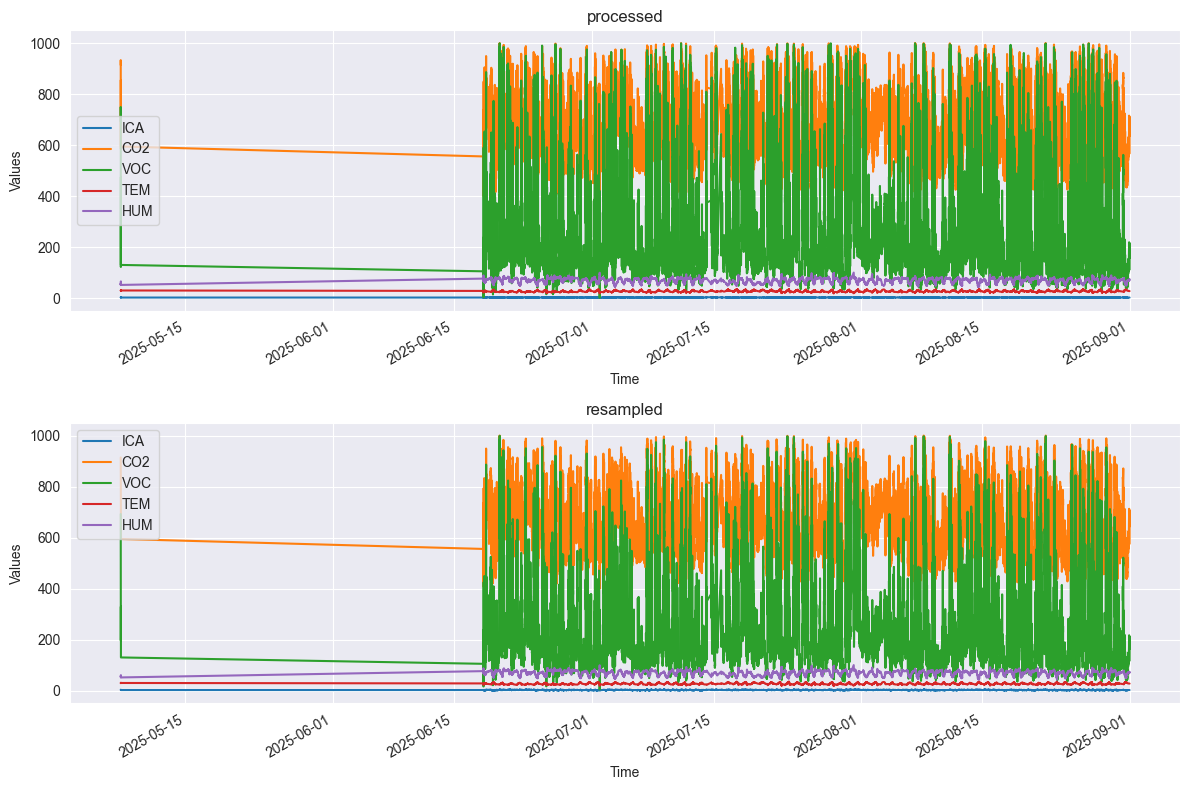

Interactive plot saved to multi_df_plot.html


In [91]:
plot_dataframes(
    [processed_stations['USAM'], resampled_stations['USAM']],
    ['processed', 'resampled'],
    output_file="multi_df_plot.html"
)

In [50]:
df_combined = merge_timeseries([processed_stations['USAM'], resampled_stations['USAM']], how='outer', fill=True, limit=2)

Merged time series saved as CSV: merged_timeseries.csv
Merged time series saved as Parquet: merged_timeseries.parquet


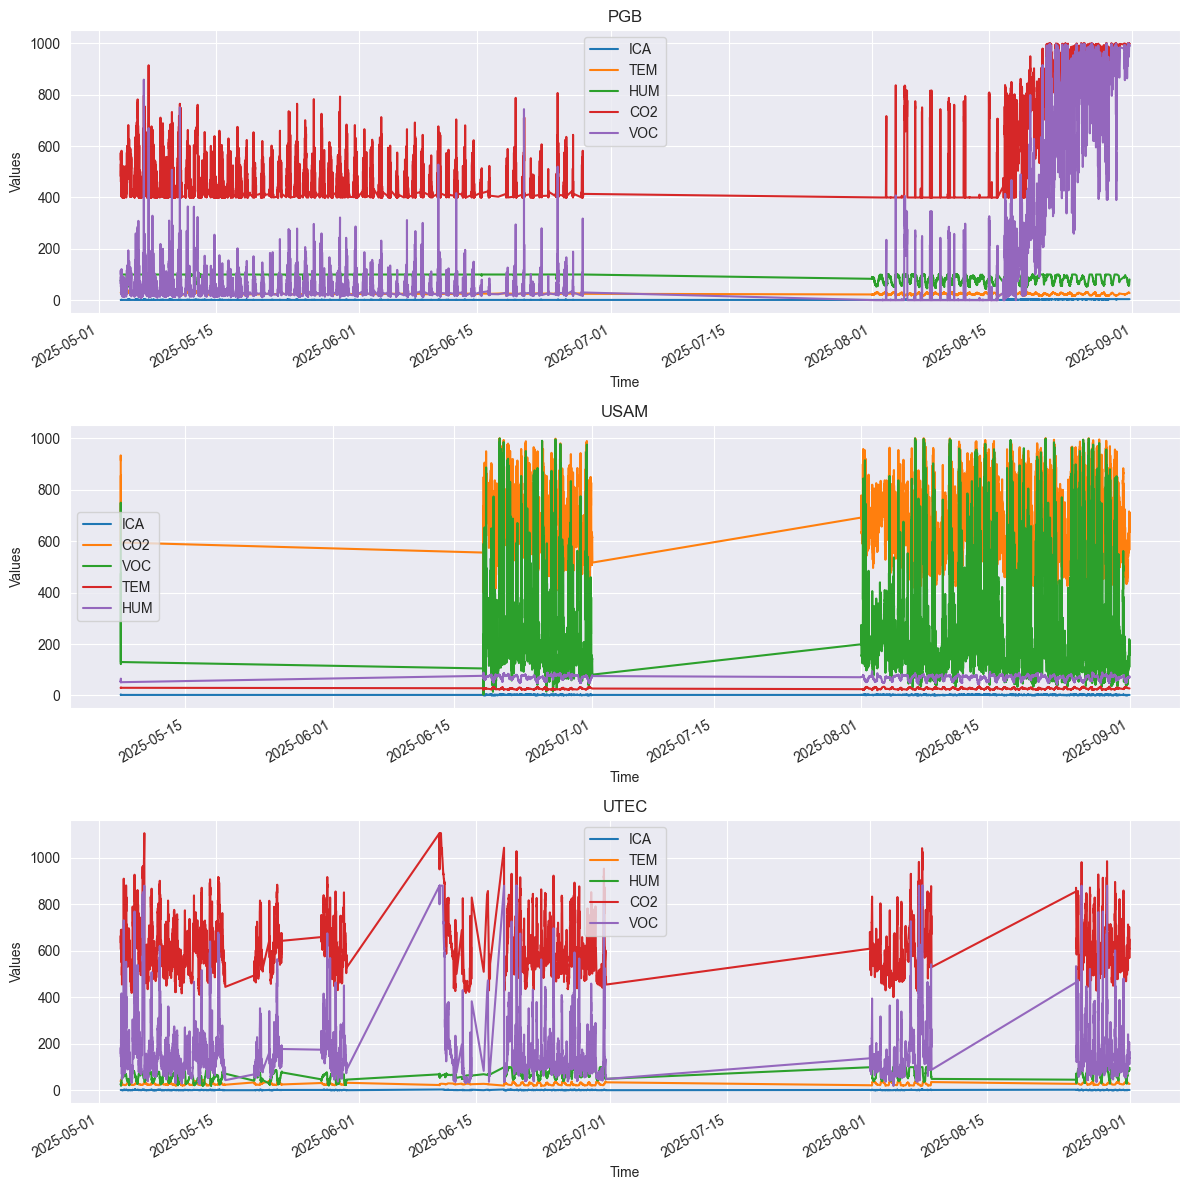

Interactive plot saved to multi_df_plot.html


In [53]:
plot_dataframes(
    [processed_stations['PGB'], processed_stations['USAM'], processed_stations['UTEC']],
    ['PGB', 'USAM', 'UTEC'],
    output_file="multi_df_plot.html"
)

In [97]:
# Save your stations without suffix
stations_to_save = ['APLAN', 'MHH', 'PFM', 'PGB', 'PLIB', 'USAM', 'UTEC']
saved_files = save_station_data(
    stations_dict=resampled_stations,
    stations=stations_to_save,
    base_path="data/air/processed/",
    save_csv=True,
    save_parquet=True,
    verbose=True
)

Saving 7 stations to data/air/processed/
Formats: CSV=True, Parquet=True
--------------------------------------------------
Saving APLAN... (shape: (15381, 5))
  ✓ CSV: data/air/processed/APLAN.csv
  ✓ Parquet: data/air/processed/APLAN.parquet

Saving MHH... (shape: (12765, 5))
  ✓ CSV: data/air/processed/MHH.csv
  ✓ Parquet: data/air/processed/MHH.parquet

Saving PFM... (shape: (6043, 5))
  ✓ CSV: data/air/processed/PFM.csv
  ✓ Parquet: data/air/processed/PFM.parquet

Saving PGB... (shape: (21699, 5))
  ✓ CSV: data/air/processed/PGB.csv
  ✓ Parquet: data/air/processed/PGB.parquet

Saving PLIB... (shape: (10653, 5))
  ✓ CSV: data/air/processed/PLIB.csv
  ✓ Parquet: data/air/processed/PLIB.parquet

Saving USAM... (shape: (20742, 5))
  ✓ CSV: data/air/processed/USAM.csv
  ✓ Parquet: data/air/processed/USAM.parquet

Saving UTEC... (shape: (21961, 5))
  ✓ CSV: data/air/processed/UTEC.csv
  ✓ Parquet: data/air/processed/UTEC.parquet

All stations saved successfully!


In [55]:
df = pd.read_csv("data/air/processed/PGB.csv", index_col=0, parse_dates=True)

In [56]:
df

,ICA,TEM,HUM,CO2,VOC
Timestamp,,,,,
2025-05-03 15:05:00+00:00,1.0,29.60,76.34,546.0,101.0
2025-05-03 15:10:00+00:00,1.0,29.77,77.99,574.0,116.0
2025-05-03 15:15:00+00:00,1.0,29.92,75.94,492.0,70.0
2025-05-03 15:20:00+00:00,1.0,29.92,75.94,492.0,70.0
2025-05-03 15:25:00+00:00,1.0,29.86,75.10,482.0,64.0
...,...,...,...,...,...
2025-08-31 15:25:00+00:00,4.0,28.13,66.99,998.0,988.0
2025-08-31 15:30:00+00:00,4.0,28.13,66.99,998.0,988.0
2025-08-31 16:10:00+00:00,4.0,27.32,80.78,999.0,991.0


In [57]:
df = pd.read_parquet("data/air/processed/PGB.parquet")

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15524 entries, 2025-05-03 15:05:00+00:00 to 2025-08-31 16:20:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ICA     15524 non-null  float64
 1   TEM     15524 non-null  float64
 2   HUM     15524 non-null  float64
 3   CO2     15524 non-null  float64
 4   VOC     15524 non-null  float64
dtypes: float64(5)
memory usage: 727.7 KB


In [59]:
def create_complemented_dataframe(df_base, df_complement, columns=['TEM', 'HUM', 'CO2','VOC']):
    """Use base dataframe and fill missing values with complement dataframe"""
    df_result = df_base.copy()

    for col in columns:
        if col in df_base.columns and col in df_complement.columns:
            complement_aligned = df_complement[col].reindex(df_base.index)
            df_result[col] = df_result[col].fillna(complement_aligned)

    return df_result

# PGB as base, fill gaps with USAM
df_complemented = create_complemented_dataframe(processed_stations['PGB'], processed_stations['USAM'])

<Axes: xlabel='Timestamp'>

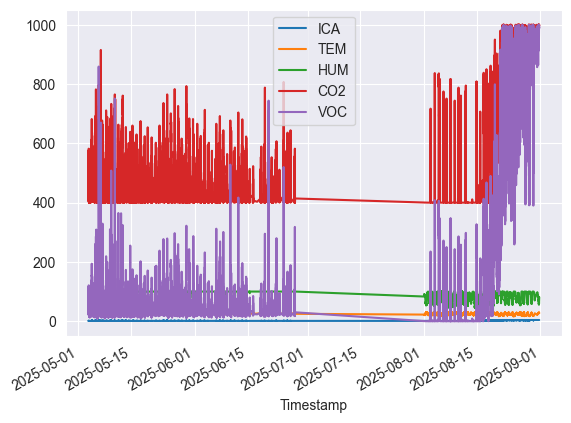

In [60]:
df_complemented.plot()

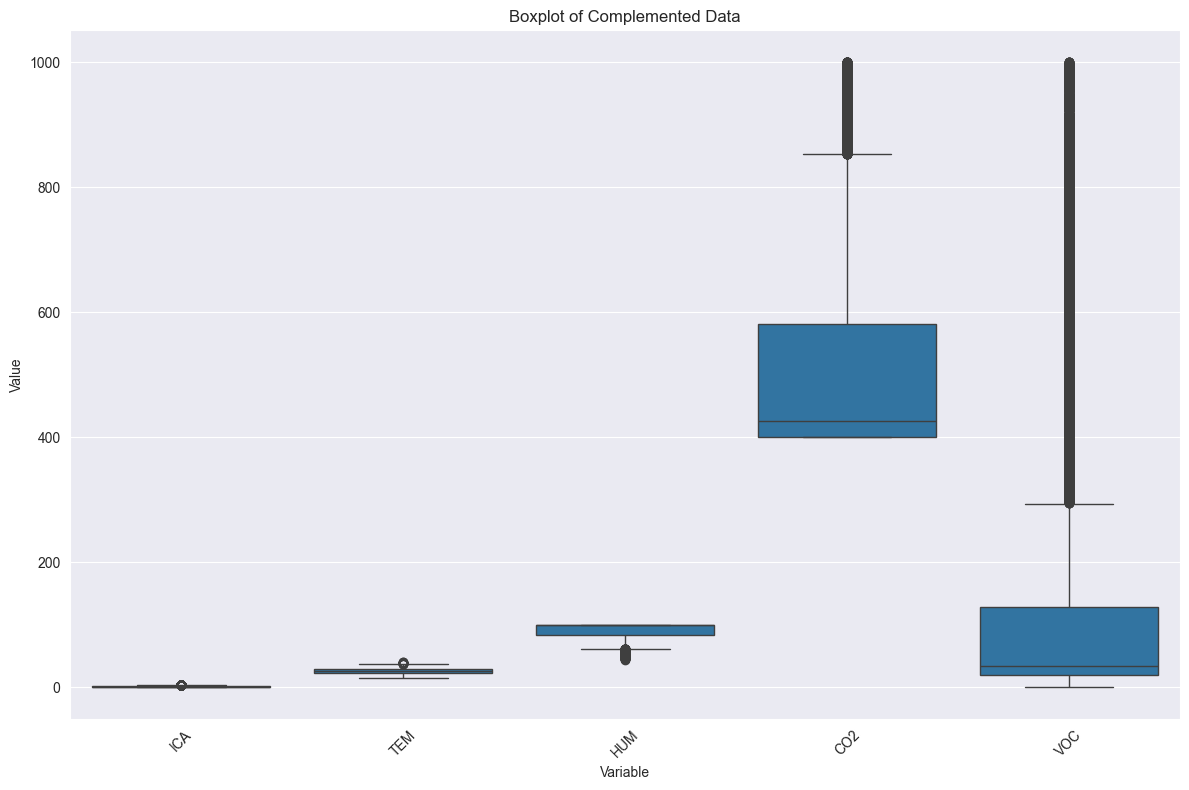

In [92]:
import seaborn as sns

plt.figure(figsize=(12, 8))
# Melt dataframe for seaborn
df_melted = df_complemented.melt(var_name='Variable', value_name='Value')
sns.boxplot(data=df_melted, x='Variable', y='Value')
plt.xticks(rotation=45)
plt.title('Boxplot of Complemented Data')
plt.tight_layout()
plt.show()

In [62]:
df_complemented.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16655 entries, 2025-05-03 15:06:00+00:00 to 2025-08-31 16:20:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ICA     16655 non-null  int64  
 1   TEM     16655 non-null  float64
 2   HUM     16655 non-null  float64
 3   CO2     16655 non-null  float64
 4   VOC     16655 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 780.7 KB


In [63]:
df_combined = merge_timeseries([processed_stations['PGB'], processed_stations['USAM']], how='outer', fill=True, limit=2)

Merged time series saved as CSV: merged_timeseries.csv
Merged time series saved as Parquet: merged_timeseries.parquet


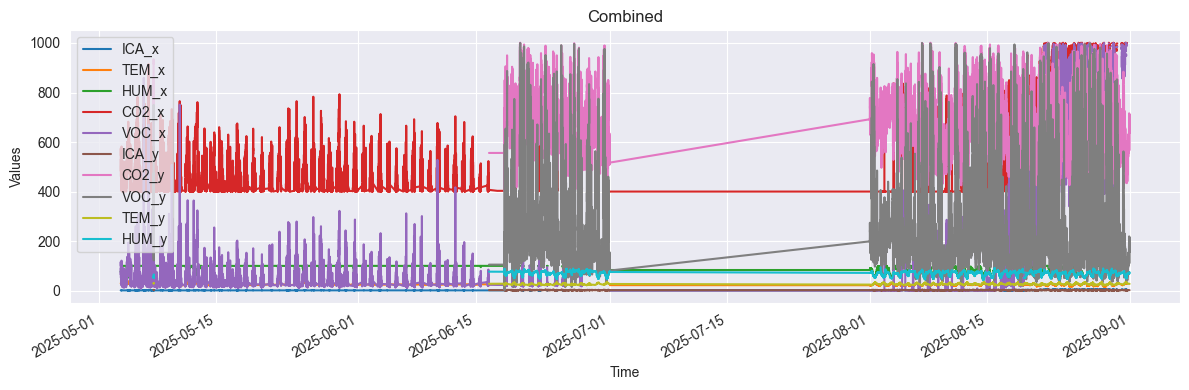

Interactive plot saved to multi_df_plot.html


In [64]:
plot_dataframes(
    [df_combined], ['Combined'], output_file="multi_df_plot.html")

In [65]:
nan_analysis = analyze_nan_values(df_complemented)

DataFrame shape: (16655, 5)
Total NaN values: 0
Columns with NaN: 0/5

NaN Summary:
Empty DataFrame
Columns: [Column, NaN_Count, NaN_Percentage, Non_NaN_Count, Total_Rows]
Index: []
